<a href="https://colab.research.google.com/github/erkamalkumar/Covid-19_data/blob/main/Tweet_emotion_recognition_with_tensorflow2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nlp

     |████████████████████████████████| 1.7 MB 5.3 MB/s 
     |████████████████████████████████| 243 kB 48.5 MB/s 


In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


In [3]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [4]:
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

In [5]:
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.7.0


In [6]:
dataset = nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


## **Importing dataset**

In [7]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [8]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [9]:
train

Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000)

In [10]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels

In [11]:
tweets, labels = get_tweet(train)

In [12]:
tweets[0], labels[0]

('i didnt feel humiliated', 'sadness')

In [13]:
tweets[2], labels[2]

('im grabbing a minute to post i feel greedy wrong', 'anger')

## **Tokenizer**

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [15]:
tokenizer = Tokenizer(num_words=10000 , oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [16]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [17]:
tweets[0]

'i didnt feel humiliated'

# **Padding and truncating sequence**
###**checking length of the tweets**
###**creating padding sequence**

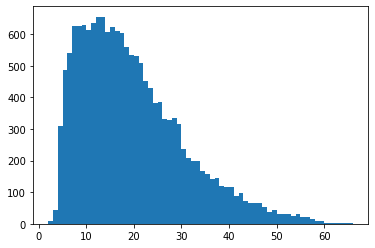

In [18]:
lengths = [len(t.split()) for t in tweets]
plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [19]:
maxlen = 50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [20]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, padding='post', truncating='post', maxlen=maxlen)
  return padded

In [21]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [22]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## **Preparing the labels**


1.   creating index to classes and classes to index dictionary
2.   converting text labels to numerical labels



In [23]:
classes = set(labels)
print(classes)

{'sadness', 'surprise', 'fear', 'joy', 'anger', 'love'}


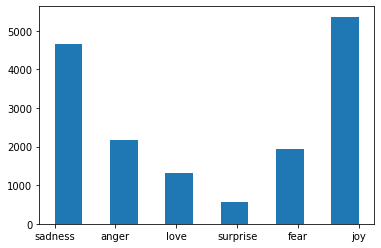

In [24]:
plt.hist(labels, bins=11)
plt.show()

In [25]:
class_to_index = dict((c,i) for i,c in enumerate(classes))
index_to_class = dict((v,k) for k, v in class_to_index.items())

In [26]:
class_to_index

{'anger': 4, 'fear': 2, 'joy': 3, 'love': 5, 'sadness': 0, 'surprise': 1}

In [27]:
index_to_class

{0: 'sadness', 1: 'surprise', 2: 'fear', 3: 'joy', 4: 'anger', 5: 'love'}

In [28]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])
train_labels = names_to_ids(labels)


In [29]:
print(train_labels[0])

0


# **Creating the model**


1.   Creating the model
2.   Compiling the model



In [30]:
model = tf.keras.models.Sequential([
                                     tf.keras.layers.Embedding(1000, 16, input_length=maxlen),
                                     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(28, return_sequences = True)),
                                     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
                                     tf.keras.layers.Dense(6, activation = 'softmax')

])
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            16000     
                                                                 
 bidirectional (Bidirectiona  (None, 50, 56)           10080     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               12320     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 38,646
Trainable params: 38,646
Non-trainable params: 0
_________________________________________________________________


# **Training the model**


1.   Preparing the validation set
2.   Training the model



In [32]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [33]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [34]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data = (val_seq, val_labels),
    epochs = 20,
    callbacks = [
                 tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 39s 60ms/step - loss: 1.4138 - accuracy: 0.4469 - val_loss: 1.0979 - val_accuracy: 0.5885
Epoch 2/20
500/500 [==============================] - 28s 56ms/step - loss: 0.8415 - accuracy: 0.6830 - val_loss: 0.7340 - val_accuracy: 0.7410
Epoch 3/20
500/500 [==============================] - 28s 56ms/step - loss: 0.5687 - accuracy: 0.8097 - val_loss: 0.5081 - val_accuracy: 0.8425
Epoch 4/20
500/500 [==============================] - 28s 56ms/step - loss: 0.4244 - accuracy: 0.8572 - val_loss: 0.4607 - val_accuracy: 0.8480
Epoch 5/20
500/500 [==============================] - 28s 56ms/step - loss: 0.3605 - accuracy: 0.8722 - val_loss: 0.4071 - val_accuracy: 0.8520
Epoch 6/20
500/500 [==============================] - 28s 57ms/step - loss: 0.3301 - accuracy: 0.8818 - val_loss: 0.4704 - val_accuracy: 0.8370
Epoch 7/20
500/500 [==============================] - 28s 56ms/step - loss: 0.3276 - accuracy: 0.8816 - val_loss: 0.3931 - val_accuracy:

# **Evaluating the model**


1.   Visualizing training history
2.   Preparing a test set
3.   Individual prediction on the test set
4.   All predictions on the test set





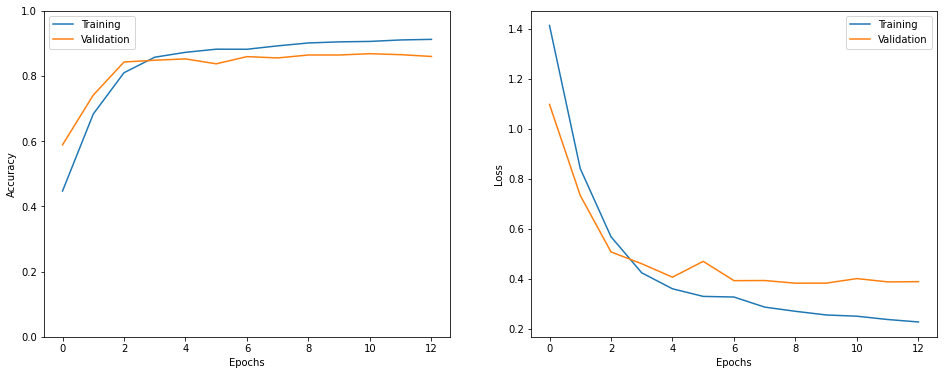

In [35]:
show_history(h)

In [38]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [39]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 1s 20ms/step - loss: 0.3783 - accuracy: 0.8620


In [48]:
i = random.randint(0, len(test_labels)-1)
print('sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('pridicted emotion', pred_class)

sentence: i don t know if it s mostly because he s forcing himself to be distracted or if he s feeling more determined or what but i think that though he s still hurting he is learning to cope with it kame takes a breath
Emotion: joy
pridicted emotion joy
